## Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

In [61]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

from heatMap import *
from dataPreparation import *
from featureExtraction import *
from classifier import *

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

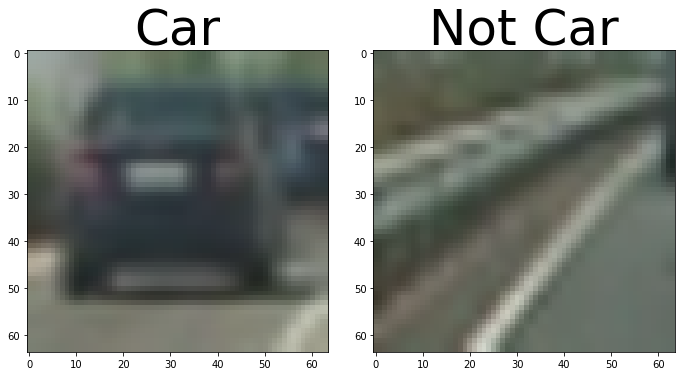

In [3]:
car =  mpimg.imread('dataset/vehicles/GTI_Far/image0000.png')
notCar =  mpimg.imread('dataset/non-vehicles/GTI/image7.png')
# Plot the car and not car
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9))
f.tight_layout()
ax1.imshow(car)
ax1.set_title('Car', fontsize=50)
ax2.imshow(notCar)
ax2.set_title('Not Car', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

I started reading sample images provided which are Car and Non Car from the dataset. Above is an example of the vehicles and non vehicles classes.

Next I started reading generating the HOG features of a randomly selected Car and Non Car.

I then explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed images from each of the two classes and displayed them to get a feel for what the skimage.hog() output looks like.

Here is an example using the RGB color space and HOG parameters of orientations=8, pixels_per_cell=(8, 8) and cells_per_block=(2, 2):

In [10]:
def addImages(images):
    results = []
    for image in images:
        results.append(image)
    return results

def getCars():
    cars = []
    carFar = glob.glob("dataset/vehicles/GTI_Far/*.png")
    carLeft = glob.glob("dataset/vehicles/GTI_Left/*.png")
    carMiddleClose = glob.glob("dataset/vehicles/GTI_MiddleClose/*.png")
    carRight = glob.glob("dataset/vehicles/GTI_Right/*.png")
    carKitti = glob.glob("dataset/vehicles/KITTI_extracted/*.png")
    cars = addImages(carFar) + addImages(carLeft) + addImages(carMiddleClose) + addImages(carRight) + addImages(carKitti)
    return cars

def getNonCars():
    notcars = []
    notCarImagesExtras = glob.glob("dataset/non-vehicles/Extras/*png")
    notCarImagesExtrasGTI = glob.glob("dataset/non-vehicles/GTI/*png")
    notcars = addImages(notCarImagesExtras) + addImages(notCarImagesExtrasGTI)
    return notcars

# Read mages
notcars = getNonCars()
cars = getCars()
len(notcars + cars)

17760

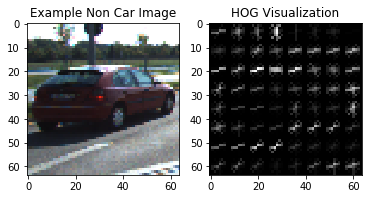

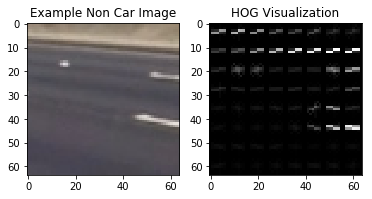

In [15]:

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


# Generate a random index to look at a not car image
ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and settled for the following parameters

- color_space = 'YCrCb'
- spatial_size = (16, 16)
- hist_bins = 16
- orient = 9
- pix_per_cell = 8
- cell_per_block = 2
- hog_channel = 'ALL'
- spatial_feat = True
- hist_feat = True
- hog_feat = True

The color space YCrCb is chosen, because I found the classifier performs better for spatial features , compared to RGB, HLS and HSV


#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using the sklean libray (from sklearn.svm import LinearSVC). The extract_features method code can be found in featureExtraction.py line 55.

The car features and notcar features are then normalized as shown in the plot below

#### Features Classifier

In [16]:
### These parameters can be tweaked to see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

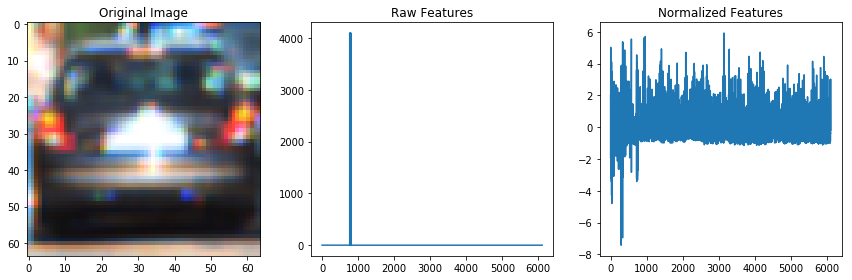

In [17]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [20]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial_size[0],
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 16 and 16 histogram bins
Feature vector length: 6108
15.97 Seconds to train SVC...
Test Accuracy of SVC =  0.9916
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
0.001 Seconds to predict 10 labels with SVC


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

Below is the sample code given in the lecture. A region of the image where the y value is set to 400 and the y ending value is 656. The image is then resize with a scale of 1.5. A cells_per_step of 2 steps for every scan is used.

The sliding window search is implmented with HOG features extraction at every step of the cell being scanned. The scanned region is then pass to the classifer to predict if it is a car or not a car.



In [92]:
ystart = 400
ystop = 656
scale = 1.5

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def find_cars(img):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

A test on car detection is done with the test images. As you may see there are false positives detection and detections detection in the results, which is very poor. Luckily we can build a heat map from these detections in order to combine overlapping detections and remove false positives. The code for the heat map is located in heatMap.py

### Find cars on test1.jpg

In [93]:
img = mpimg.imread("../test_images/test1.jpg")
out_img1 = find_cars(img)

img = mpimg.imread("../test_images/test2.jpg")
out_img2 = find_cars(img)

img = mpimg.imread("../test_images/test3.jpg")
out_img3 = find_cars(img)

img = mpimg.imread("../test_images/test4.jpg")
out_img4 = find_cars(img)

img = mpimg.imread("../test_images/test5.jpg")
out_img5 = find_cars(img)

img = mpimg.imread("../test_images/test6.jpg")
out_img6 = find_cars(img)


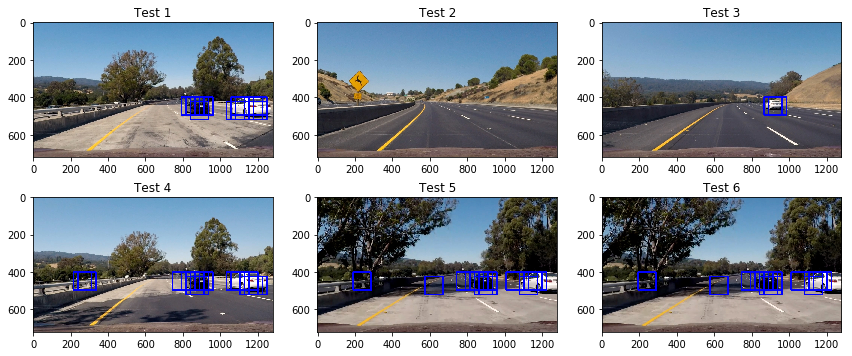

In [94]:
fig = plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(out_img1)
plt.title('Test 1')
plt.subplot(232)
plt.imshow(out_img2)
plt.title('Test 2')
plt.subplot(233)
plt.imshow(out_img3)
plt.title('Test 3')

plt.subplot(234)
plt.imshow(out_img4)
plt.title('Test 4')

plt.subplot(235)
plt.imshow(out_img5)
plt.title('Test 5')

plt.subplot(236)
plt.imshow(out_img5)
plt.title('Test 6')

fig.tight_layout()

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a 

[link to my video result](./output1.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

To filter out false positives and overlapping bounding boxes the code can be found in the heatMap.py file.

Once a car object is detected the coordinates of the car is added in into a list collection eg boxes. 
The method add_heat in the heatMap.py will scan through the list collection coordinates and add (+=1) for all pixels within windows where a positive detection is marked by the classifer.

A heat threshold is then applied to reject areas with false positive. The method apply_threshold is located in the heatMap.py file
 - eg heat_threshold = 2
 
 
Then apply 'scipy.ndimage.measurements.label()' to identify individual heat blobs in the heatmap. 
The individual heat blobs are assumed to be vehicles, and bounding boxes are apply to mark the area of each of these heat blobs. These heat maps get averaged across the last ten frames.

In [104]:
class Recent_Heat:
    def __init__(self):
        self.heat_list = []
    def add_heat(self, heat):
        self.heat_list.append(heat)

rec_heat = Recent_Heat()

## Find cars and appplying heatmap threshold
# Scales to iterate through for window searches
scale = [1.1, 1.5, 1.9, 2.3]

# Frames to smooth heatmap over
heat_frames = 5

# The higher this is, the further from the decision boundary it is.
# Numbers close to zero are not very confident - this is not percentage confidence
confidence_threshold = 0.3

# Threshold for strength of heat needed to make it to final bounding box
# Helps remove false positives
heat_threshold = 3
    
    
def find_cars(img):
    """ This function is the main pipeline for vehicle detection.
    It extracts features using hog sub-sampling, and also uses color features
    in making its predictions using the already trained classifier.
    """
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    # List to put in the box coordinates for drawing
    boxes = []

    # Iterate through for each scale from the list above
    for num in scale:
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
        if num != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/num), np.int(imshape[0]/num)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # How many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
                confidence = svc.decision_function(test_features)
                test_prediction = svc.predict(test_features)

                if test_prediction == 1 and abs(confidence) > confidence_threshold:
                    xbox_left = np.int(xleft*num)
                    ytop_draw = np.int(ytop*num)
                    win_draw = np.int(window*num)
                    boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Append new heatmap to recents list
    rec_heat.add_heat(heat)

    # Drop oldest frame to have ten total for average
    if len(rec_heat.heat_list) > heat_frames:
        rec_heat.heat_list = rec_heat.heat_list[1:heat_frames+1]

    # Make into array so np.mean will calculate for each value in the image
    recent_heat_array = np.array(rec_heat.heat_list)
        
    # Take the average heat
    avg_heat = np.mean(np.array(recent_heat_array), axis=0)
    
    # Apply threshold to help remove false positives
    avg_heat = apply_threshold(avg_heat,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(avg_heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return draw_img, heatmap

In [105]:
img = mpimg.imread("../test_images/test1.jpg")
r_out_img1, label1 = find_cars(img)

img = mpimg.imread("../test_images/test2.jpg")
r_out_img2, label2 = find_cars(img)

img = mpimg.imread("../test_images/test3.jpg")
r_out_img3, label3 = find_cars(img)

img = mpimg.imread("../test_images/test4.jpg")
r_out_img4, label4 = find_cars(img)

img = mpimg.imread("../test_images/test5.jpg")
r_out_img5, label5 = find_cars(img)

img = mpimg.imread("../test_images/test6.jpg")
r_out_img6, label6 = find_cars(img)

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:

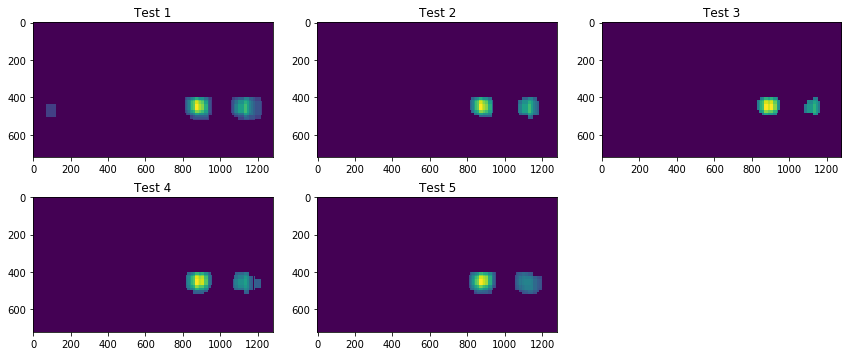

In [103]:
fig = plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(label1)
plt.title('Test 1')
plt.subplot(232)
plt.imshow(label2)
plt.title('Test 2')
plt.subplot(233)
plt.imshow(label3)
plt.title('Test 3')

plt.subplot(234)
plt.imshow(label4)
plt.title('Test 4')

plt.subplot(235)
plt.imshow(label5)
plt.title('Test 5')

plt.subplot(235)
plt.imshow(label6)
plt.title('Test 5')

fig.tight_layout()

### Here the resulting bounding boxes are drawn onto the last frame in the series:

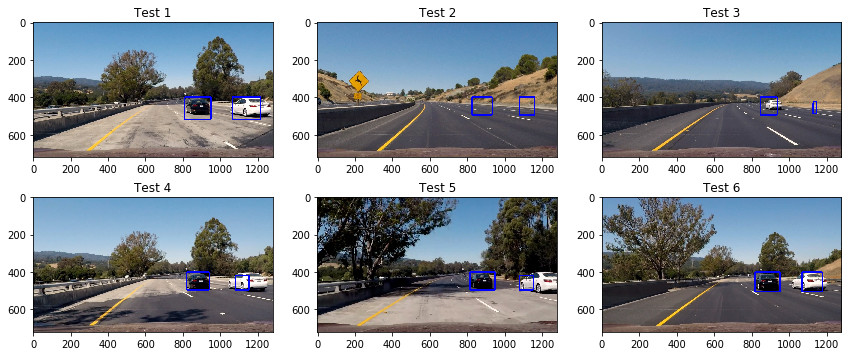

In [106]:
fig = plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(r_out_img1)
plt.title('Test 1')
plt.subplot(232)
plt.imshow(r_out_img2)
plt.title('Test 2')
plt.subplot(233)
plt.imshow(r_out_img3)
plt.title('Test 3')

plt.subplot(234)
plt.imshow(r_out_img4)
plt.title('Test 4')

plt.subplot(235)
plt.imshow(r_out_img5)
plt.title('Test 5')

plt.subplot(236)
plt.imshow(r_out_img6)
plt.title('Test 6')

fig.tight_layout()

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?


It took me awhile to understand the concepts. By run through the video lessons and tutorial a few times, I began to grasp the idea on the module. 

In terms of processing the video to produce the detected vechicle, it took around 50 mins. This is quite poor in terms of performance.

A bigger dataset to train the model and to explore different supervised learning techniques might make the model more robuts.


Questions
- Why is Test 2 detecting heat and mark an road as a car in test2.jpg
- Any idea how to make the processing faster?
- Any reference or resources to refer for vehicle detection ?
